In [9]:
import numpy as np
from numba import jit
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import pyvista as pv
from scipy import interpolate
import surface_normalize

In [21]:
etching = np.load('./Data/For_etching_transport_TS60_deposit_0618_linear_paper_NoDSMC2_empty2.npy')

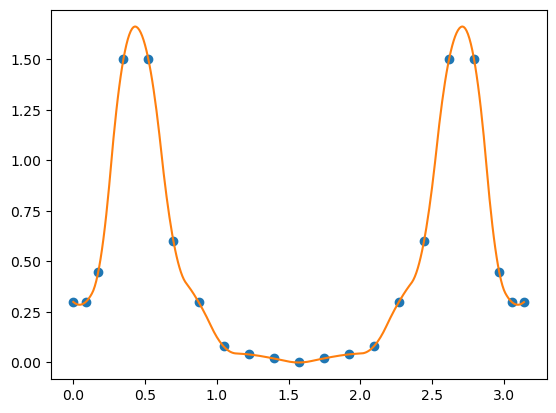

In [22]:
yield_hist = np.array([[0.3, 0.3, 0.45,  1.5,  1.5,  0.6, 0.3, 0.08, 0.04, 0.02,  0, \
                        0.02, 0.04, 0.08, 0.3, 0.6, 1.5, 1.5, 0.45, 0.3, 0.3], \
                        [  0,  5,   10,   20,   30,   40,   50,   60,   70,   80, 90, \
                         100, 110, 120, 130, 140, 150, 160, 170, 175, 180]])
yield_hist[1] *= np.pi/180
yield_func = interpolate.interp1d(yield_hist[1], yield_hist[0], kind='quadratic')

xnew = np.arange(0, np.pi, 0.01)
# xnew = np.array([])
ynew = yield_func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(yield_hist[1], yield_hist[0], 'o', xnew, ynew, '-')
plt.show()

In [23]:
testpy = surface_normalize.surface_normal(center_with_direction=np.array([[50,50,10]]),range3D=np.array([[0, 100, 0, 100, 0, 150]]), InOrOut=[1],celllength=1e-9,  yield_hist=yield_hist)

In [35]:
getdata = testpy.get_pointcloud(etching[:, :, :])

In [6]:
point_cloud = pv.PolyData(getdata[:, 3:])
vectors = getdata[:, :3]

point_cloud['vectors'] = vectors
arrows = point_cloud.glyph(
    orient='vectors',
    scale=1000,
    factor=2,
)

# Display the arrows
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, color='maroon', point_size=5.0, render_points_as_spheres=True)
plotter.add_mesh(arrows, color='lightblue')
# plotter.add_point_labels([point_cloud.center,], ['Center',],
#                          point_color='yellow', point_size=20)
plotter.show_grid()
plotter.show()

Widget(value='<iframe src="http://localhost:53729/index.html?ui=P_0x22e255fee10_0&reconnect=auto" class="pyvis…

In [12]:
print(getdata.shape)

print(getdata[10000])

(20530, 6)
[ 2.96875426e-02 -9.05025869e-01  4.24319250e-01  4.90000000e+01
  3.10000000e+01  4.00000000e+01]


In [149]:

# @jit(nopython=True)
def ray_point_cloud_intersection_vectorized(ray_origin, ray_direction, point_cloud):
    # 将光线方向标准化（单位向量）
    ray_direction = ray_direction / np.linalg.norm(ray_direction)

    # 计算从光线起点到每个点的向量
    point_vectors = point_cloud - ray_origin

    # 计算点向量在光线方向上的投影长度
    t = np.dot(point_vectors, ray_direction)

    # 计算光线上投影点的坐标
    projections = ray_origin + np.outer(t, ray_direction)

    # 计算当前点到投影点的距离
    distances = np.linalg.norm(point_cloud - projections, axis=1)

    indice = np.where(distances < 0.5)[0]
    # 如果没有点满足条件，则返回空结果
    if indice.size == 0:
        return None
    near_point = point_cloud[indice]

    distances_near_point = np.linalg.norm(ray_origin - near_point, axis=1)
    # 找到最小距离和最近点
    min_index = np.argmin(distances_near_point)
    closest_point = point_cloud[indice[min_index]]
    # min_distance = distance_in[min_index]

    return closest_point


In [150]:
ray_origin = np.array([10.3, 10.1, 160])
ray_direction = np.array([0, 0, -10])

closest_point = ray_point_cloud_intersection_vectorized(ray_origin, ray_direction, getdata[:, 3:])

In [151]:
closest_point

array([ 10.,  10., 129.])

In [154]:
print(etching.shape)

(100, 100, 160)


In [232]:
def find_intersection_face(ray_origin, ray_direction, box_center, box_half_size):
    # 计算立方体的最小角和最大角
    min_corner = box_center - box_half_size
    max_corner = box_center + box_half_size

    # 初始化记录相交时间的数组和相交面的数组
    t_near = -np.inf
    t_far = np.inf
    hit_normal = np.array([0, 0, 0])

    # 遍历三个轴（x, y, z）
    for i in range(3):
        if ray_direction[i] != 0:
            # 计算 t1 和 t2
            t1 = (min_corner[i] - ray_origin[i]) / ray_direction[i]
            t2 = (max_corner[i] - ray_origin[i]) / ray_direction[i]
            
            # 交换 t1 和 t2，如果 t1 > t2
            if t1 > t2:
                t1, t2 = t2, t1
            
            # 更新 t_near 和 t_far
            if t1 > t_near:
                t_near = t1
                hit_normal = np.array([0, 0, 0])
                hit_normal[i] = -1 if ray_direction[i] > 0 else 1
            
            if t2 < t_far:
                t_far = t2

            # 检查是否存在相交
            if t_near > t_far or t_far < 0:
                return None, None  # 不相交

    # 确定哪个面被击中
    if np.array_equal(hit_normal, [-1, 0, 0]):
        return 0  #"Left"
    elif np.array_equal(hit_normal, [1, 0, 0]):
        return 1  #"Right"
    elif np.array_equal(hit_normal, [0, -1, 0]):
        return 2  #"Front"
    elif np.array_equal(hit_normal, [0, 1, 0]):
        return 3  #"Back"
    elif np.array_equal(hit_normal, [0, 0, -1]):
        return 4  #"Bottom"
    elif np.array_equal(hit_normal, [0, 0, 1]):
        return 5  #"Top"
    return None


# 示例使用
ray_origin = np.array([5, 5.1, 5])
ray_direction = np.array([-1, -1, -1])
box_center = np.array([0, 0, 0])
box_half_size = np.array([1, 1, 1])

hit_face = find_intersection_face(ray_origin, ray_direction, box_center, box_half_size)
print(f"Hit face: {hit_face}")

Hit face: 3


In [231]:
# import numpy as np

def find_intersection_face(ray_origin, ray_direction, box_center, box_half_size):
    # 计算立方体的最小角和最大角
    min_corner = box_center - box_half_size
    max_corner = box_center + box_half_size

    # 初始化记录相交时间的数组和相交面的数组
    t_near = -np.inf
    t_far = np.inf
    hit_normal = np.array([0, 0, 0])

    # 遍历三个轴（x, y, z）
    for i in range(3):
        if ray_direction[i] != 0:
            # 计算 t1 和 t2
            t1 = (min_corner[i] - ray_origin[i]) / ray_direction[i]
            t2 = (max_corner[i] - ray_origin[i]) / ray_direction[i]
            
            # 交换 t1 和 t2，如果 t1 > t2
            if t1 > t2:
                t1, t2 = t2, t1
            
            # 更新 t_near 和 t_far
            if t1 > t_near:
                t_near = t1
                hit_normal = np.array([0, 0, 0])
                hit_normal[i] = -1 if ray_direction[i] > 0 else 1
            
            if t2 < t_far:
                t_far = t2

            # 检查是否存在相交
            if t_near > t_far or t_far < 0:
                return None, None  # 不相交

    # 确定哪个面被击中
    hit_face = determine_face(hit_normal)

    return hit_face, t_near

def determine_face(hit_normal):
    # 根据 hit_normal 的方向确定被击中的面
    if np.array_equal(hit_normal, [-1, 0, 0]):
        return "Left"
    elif np.array_equal(hit_normal, [1, 0, 0]):
        return "Right"
    elif np.array_equal(hit_normal, [0, -1, 0]):
        return "Front"
    elif np.array_equal(hit_normal, [0, 1, 0]):
        return "Back"
    elif np.array_equal(hit_normal, [0, 0, -1]):
        return "Bottom"
    elif np.array_equal(hit_normal, [0, 0, 1]):
        return "Top"
    return None

# 示例使用
ray_origin = np.array([5, 5.1, 5])
ray_direction = np.array([-1, -1, -1])
box_center = np.array([0, 0, 0])
box_half_size = np.array([1, 1, 1])

hit_face, t_near = find_intersection_face(ray_origin, ray_direction, box_center, box_half_size)
print(f"Hit face: {hit_face}, t_near: {t_near}")


Hit face: Back, t_near: 4.1


In [220]:
# 示例使用
ray_origin = np.array([0, 10, 0])
ray_direction = np.array([0.0001, -1, 0.001])
box_center = np.array([0, 0, 0])
box_half_size = np.array([1, 1, 1])

hit_face, t_near = find_intersection_face(ray_origin, ray_direction, box_center, box_half_size)
print(f"Hit face: {hit_face}, t_near: {t_near}")

Hit face: Back, t_near: 9.0


In [155]:
print(etching[closest_point[0].astype(int),closest_point[1].astype(int), closest_point[2].astype(int)])

0.0


In [139]:
getdata = testpy.get_pointcloud(etching[:, :, :])

In [ ]:
film_elemnt = np.array([10, 20])

In [156]:
a = np.array((1,2,3,5))
b = np.array((4,5,6))
np.hstack((a,b))

array([1, 2, 3, 5, 4, 5, 6])

In [185]:
react_table = np.array([[[0.700, 0, 1], [0.300, 0, 1]],
                        [[0.200, -1, 0], [0.075, 0, -1]]])

film_elemnt = np.array([10, 20], dtype=float)

def reaction(gas, film):
    # 计算总长度
    total_length = int(film.sum())
    
    # 预分配数组
    reaction_type = np.empty(total_length, dtype=float)
    reaction_rate = np.empty(total_length, dtype=float)
    
    # 填充数组
    current_index = 0
    for i in range(film.shape[0]):
        length = int(film[i])
        reaction_type[current_index:current_index+length] = i
        reaction_rate[current_index:current_index+length] = react_table[gas,i,0]
        current_index += length
    
    reaction_list = np.random.rand(int(film.sum()))

    reaction_selection = reaction_rate > reaction_list
    reaction_choice = np.random.choice(np.where(reaction_selection == True)[0], 1)
    reaction_particle = reaction_type[reaction_choice].astype(int)

    film += react_table[gas, reaction_particle, 1:][0]

    return film

print(reaction(0, film_elemnt))

[10. 21.]


In [243]:
# import numpy as np

# 定义反应表和初始的 film 元素
react_table = np.array([[[0.700, 0, 1], [0.300, 0, 1]],
                        [[0.200, -1, 0], [0.075, 0, -1]]])
film_elemnt = np.array([1, 0], dtype=float)

def reaction(gas, film):
    # 计算总长度
    total_length = int(film.sum())

    # 预分配反应类型和反应速率
    reaction_type = np.empty(total_length, dtype=int)
    reaction_rate = np.empty(total_length, dtype=float)

    # 填充反应类型和反应速率
    current_index = 0
    for i in range(film.shape[0]):
        length = int(film[i])
        reaction_type[current_index:current_index + length] = i
        reaction_rate[current_index:current_index + length] = react_table[gas, i, 0]
        current_index += length

    # 生成随机数列以确定反应发生的概率
    reaction_list = np.random.rand(total_length)

    # 筛选出发生反应的粒子
    reaction_indices = np.where(reaction_rate > reaction_list)[0]
    
    # 如果有反应发生，随机选择一个反应
    if reaction_indices.size > 0:
        reaction_choice = np.random.choice(reaction_indices, 1)
        reaction_particle = reaction_type[reaction_choice][0]
        # print(reaction_particle)
        # 更新 film 元素的状态
        film += react_table[gas, reaction_particle, 1:]
        return film, reaction_particle, np.sum(react_table[gas, reaction_particle, 1:]) # film, react_type, etchingDepo 
    else:
        return film, -1, 0


# 调用函数并输出结果
print(reaction(1, film_elemnt))


(array([1., 0.]), -1, 0)


In [198]:
film = np.ones((10, 10, 10, 3))

sumfilm = np.sum(film, axis=-1)
print(sumfilm.shape)

(10, 10, 10)


In [ ]:
    # # 确定哪个面被击中
    # if np.array_equal(hit_normal, [-1, 0, 0]):
    #     return 0  #"Left"
    # elif np.array_equal(hit_normal, [1, 0, 0]):
    #     return 1  #"Right"
    # elif np.array_equal(hit_normal, [0, -1, 0]):
    #     return 2  #"Front"
    # elif np.array_equal(hit_normal, [0, 1, 0]):
    #     return 3  #"Back"
    # elif np.array_equal(hit_normal, [0, 0, -1]):
    #     return 4  #"Bottom"
    # elif np.array_equal(hit_normal, [0, 0, 1]):
    #     return 5  #"Top"
    # return None
ray_origin = np.array([10.3, 10.1, 160])
ray_direction = np.array([0, 0, -10])

closest_point = ray_point_cloud_intersection_vectorized(ray_origin, ray_direction, getdata[:, 3:])


def surface_addition(film, react_point, react, flux):
    film[react_point[0], react_point[1], react_point[2], flux] += react[2]
    film[react_point[0], react_point[1], react_point[2], 6:] += react[0]
    return film

In [246]:
a = np.arange(10)

print(a[:6])
print(a[6:])

[0 1 2 3 4 5]
[6 7 8 9]


In [289]:
a = np.array([0.0, 0.33, 0.5, 0.7, 1.0])
b = np.random.rand()

# 创建布尔掩码，找出满足条件的区间
mask = (b > a[:-1]) & (b <= a[1:])
print(mask)
print(b)
# 找到第一个满足条件的区间索引
indices = np.where(mask)[0]
print(indices[0])
if indices.size > 0:
    index = indices[0]
    print('get')
    print(index)
    print(b)
else:
    print('b is not in any interval')


[False False False  True]
0.9403378234442834
3
get
3
0.9403378234442834


In [278]:
a = np.array([[0.0, 0.33, 0.5, 0.7, 1.0], [0.0, 0.33, 0.5, 0.7, 1.2]])

print(np.where(a > 1.4))

b = np.where(a > 1.4)
print(b[0])
print(b[0].size)

print(a[b])

(array([], dtype=int64), array([], dtype=int64))
[]
0
[]


In [280]:
a = np.array([10, 30, 34, 40, 33])
b = np.array([0, 12, 5, 6, 7])
c = a-b
print(c)

[10 18 29 34 26]


In [286]:
# 原始数组 a
a = np.array([10, 30, 34, 40, 33])

# 总抽取数量 N
N = int(np.sum(a)/2)
print(N)

# 初始化 b 数组
b = np.zeros_like(a)

# 计算总和
total_sum = a.sum()

if total_sum < N:
    raise ValueError("N exceeds the total number of available elements in a.")

# 随机抽取元素
remaining_to_draw = N
while remaining_to_draw > 0:
    # 随机选择一个位置
    idx = np.random.choice(np.where(a > 0)[0])
    # 在选择的位置随机抽取数量，最大为a[idx]和remaining_to_draw之间的最小值
    draw = np.random.randint(0, min(a[idx], remaining_to_draw) + 1)
    # 更新 b 和 a
    b[idx] += draw
    a[idx] -= draw
    remaining_to_draw -= draw

print("随机抽取数量 b:", b)
print("剩余的 a 数组:", a)


73
随机抽取数量 b: [ 0 28 21  4 20]
剩余的 a 数组: [10  2 13 36 13]


In [344]:
a = np.array([10, 30, 34, 40, 33])
print(a.size)
# 总抽取数量 N
N = 30

# 初始化 b 数组
b = np.zeros_like(a)

# 计算总和
total_sum = a.sum()

if total_sum < N:
    raise ValueError("N exceeds the total number of available elements in a.")

# 随机选择抽取的顺序
indices = np.repeat(np.arange(a.size), a)
print(indices)
np.random.shuffle(indices)

# 选择前 N 个，统计各类别的抽取数量
unique, counts = np.unique(indices[:N], return_counts=True)

# 更新 b 和 a
b[unique] += counts
a[unique] -= counts

print("随机抽取数量 b:", b)
print("剩余的 a 数组:", a)

5
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
随机抽取数量 b: [5 7 8 7 3]
剩余的 a 数组: [ 5 23 26 33 30]


In [ ]:
    # # 确定哪个面被击中
    # if np.array_equal(hit_normal, [-1, 0, 0]):
    #     return 0  #"Left"
    # elif np.array_equal(hit_normal, [1, 0, 0]):
    #     return 1  #"Right"
    # elif np.array_equal(hit_normal, [0, -1, 0]):
    #     return 2  #"Front"
    # elif np.array_equal(hit_normal, [0, 1, 0]):
    #     return 3  #"Back"
    # elif np.array_equal(hit_normal, [0, 0, -1]):
    #     return 4  #"Bottom"
    # elif np.array_equal(hit_normal, [0, 0, 1]):
    #     return 5  #"Top"
    # return None

indices = np.repeat(np.arange(a.size), a)
print(indices)
np.random.shuffle(indices)

# 选择前 N 个，统计各类别的抽取数量
unique, counts = np.unique(indices[:N], return_counts=True)

# 更新 b 和 a
b[unique] += counts
a[unique] -= counts

In [578]:
def pickParticles(film, inCell, outFlow):
    # print(film[inCell[0], inCell[1], inCell[2],6:])
    # print(film[inCell[0], inCell[1], inCell[2],6:][0].size)
    indices = np.repeat(np.arange(film[inCell[0], inCell[1], inCell[2],6:][0].size), film[inCell[0], inCell[1], inCell[2],6:][0])
    np.random.shuffle(indices)
    # 选择前 N 个，统计各类别的抽取数量
    print(indices)
    unique, counts = np.unique(indices[:outFlow[0]], return_counts=True) # np.unique(indices[:N+1], return_counts=True)
    print(counts)
    print(unique)
    print('----unique----')
    film[inCell[0], inCell[1], inCell[2], unique+6] -= counts
    return film, unique, counts

In [594]:
def enclose_overflow(film, i, j, k):
    if np.sum(film[i-1, j, k, 6:]) > 30:
        if (np.sum(film[i-1-1, j, k, 6:]) > 0) & (np.sum(film[i-1, j-1, k, 6:]) > 0) & (np.sum(film[i-1, j+1, k, 6:]) > 0) \
            & (np.sum(film[i-1, j, k-1, 6:]) > 0) & (np.sum(film[i-1, j, k+1, 6:]) > 0):
            inCell = np.array([i-1, j, k])
            overflow = np.sum(film[i-1, j, k, 6:]) - 30
            film, unique, counts = pickParticles(film, inCell, overflow)
            film[i, j, k][unique+6] += counts
    elif np.sum(film[i+1, j, k, 6:]) > 30:
        if (np.sum(film[i+1+1, j, k, 6:]) > 0) & (np.sum(film[i+1, j-1, k, 6:]) > 0) & (np.sum(film[i+1, j+1, k, 6:]) > 0) \
            & (np.sum(film[i+1, j, k-1, 6:]) > 0) & (np.sum(film[i+1, j, k+1, 6:]) > 0):
            inCell = np.array([i+1, j, k])
            overflow = np.sum(film[i+1, j, k]) - 30
            film, unique, counts = pickParticles(film, inCell, overflow)
            film[i, j, k][unique+6] += counts
    elif np.sum(film[i, j-1, k, 6:]) > 30:
        if (np.sum(film[i-1, j-1, k, 6:]) > 0) & (np.sum(film[i, j-1-1, k, 6:]) > 0) & (np.sum(film[i+1, j, k, 6:]) > 0) \
            & (np.sum(film[i, j-1, k-1, 6:]) > 0) & (np.sum(film[i, j-1, k+1, 6:]) > 0):
            inCell = np.array([i, j-1, k])
            overflow = np.sum(film[i, j-1, k]) - 30
            film, unique, counts = pickParticles(film, inCell, overflow)
            film[i, j, k][unique+6] += counts
    elif np.sum(film[i, j+1, k, 6:]) > 30:
        if (np.sum(film[i-1, j+1, k, 6:]) > 0) & (np.sum(film[i+1, j+1, k, 6:]) > 0) & (np.sum(film[i, j+1+1, k, 6:]) > 0) \
            & (np.sum(film[i, j+1, k-1, 6:]) > 0) & (np.sum(film[i, j+1, k+1, 6:]) > 0):
            inCell = np.array([i, j+1, k])
            overflow = np.sum(film[i, j+1, k]) - 30
            film, unique, counts = pickParticles(film, inCell, overflow)
            film[i, j+1, k][unique+6] += counts
    elif np.sum(film[i, j, k-1, 6:]) > 30:
        if (np.sum(film[i-1, j, k-1, 6:]) > 0) & (np.sum(film[i+1, j, k-1, 6:]) > 0) & (np.sum(film[i, j+1, k-1, 6:]) > 0) \
            & (np.sum(film[i, j, k-1-1, 6:]) > 0) & (np.sum(film[i, j-1, k, 6:]) > 0):
            inCell = np.array([i, j, k-1])
            overflow = np.sum(film[i, j, k-1]) - 30
            film, unique, counts = pickParticles(film, inCell, overflow)
            film[i, j, k-1][unique+6] += counts
    elif np.sum(film[i, j, k+1, 6:]) > 30:
        if (np.sum(film[i-1, j, k+1, 6:]) > 0) & (np.sum(film[i+1, j, k+1, 6:]) > 0) & (np.sum(film[i, j+1, k+1, 6:]) > 0) \
            & (np.sum(film[i, j-1, k, 6:]) > 0) & (np.sum(film[i, j, k+1+1, 6:]) > 0):
            inCell = np.array([i, j, k+1])
            overflow = np.sum(film[i, j, k+1]) - 30
            film, unique, counts = pickParticles(film, inCell, overflow)
            film[i, j, k+1][unique+6] += counts
    return film

In [595]:
a = np.array([10, 30, 34, 40, 33])
b = np.zeros(a.shape[0] + 1)
asum = np.sum(a)

print(np.cumsum(a))
# 使用累积和计算 b 的值
b[1:] = np.cumsum(a) / asum

print(b)

[ 10  40  74 114 147]
[0.         0.06802721 0.27210884 0.50340136 0.7755102  1.        ]


In [606]:
# film([x,y,z] Left Right Front Back Bottom Top, type1, type2, ...)

def surface_advancement(film, type):
    N = int(30)
    sumfilm = np.sum(film[:, :, :, 6:], axis=-1, dtype=int)
    print(sumfilm[:, :, 2])
    if type == 1:
        upperCell = np.where(sumfilm > 2*N)
        # lowerCell = np.where(sumfilm < N/5)
        # upperCell = sumfilm > 2*N
        # lowerCell = sumfilm < N/5
        print(upperCell)
        # print(lowerCell)
        if upperCell[0].size == 0:
            return film
        else:
            outFlowParticles = sumfilm[upperCell] - N
            flux = film[upperCell[0], upperCell[1], upperCell[2], :6][0]
            print(flux)
            print('----flux----')
            flux_rate = np.zeros(flux.shape[0] + 1)
            flux_rate[1:] = np.cumsum(flux)/np.sum(flux)
            flow_random = np.random.rand()
            mask = (flow_random > flux_rate[:-1]) & (flow_random <= flux_rate[1:])
            print(mask)
            flow_choice = np.where(mask)[0]
            print(flow_choice)
            # indices = np.repeat(np.arange(film[upperCell][6:].size), film[upperCell][6:])
            # np.random.shuffle(indices)
            # # 选择前 N 个，统计各类别的抽取数量
            # unique, counts = np.unique(indices[:N+1], return_counts=True)
            # film[upperCell[0], upperCell[1], upperCell[2]][unique+6]     -= counts
            film, unique, counts = pickParticles(film, upperCell, outFlowParticles)
            if flow_choice == 0:
                film[upperCell[0] - 1, upperCell[1], upperCell[2],unique+6] += counts
                film = enclose_overflow(film, upperCell[0] - 1, upperCell[1], upperCell[2])
            elif flow_choice == 1:
                film[upperCell[0] + 1, upperCell[1], upperCell[2],unique+6] += counts
                film = enclose_overflow(film, upperCell[0] + 1, upperCell[1], upperCell[2])
            elif flow_choice == 2:
                film[upperCell[0], upperCell[1] - 1, upperCell[2],unique+6] += counts
                film = enclose_overflow(film, upperCell[0], upperCell[1] - 1, upperCell[2])
            elif flow_choice == 3:
                film[upperCell[0], upperCell[1] + 1, upperCell[2],unique+6] += counts
                film = enclose_overflow(film, upperCell[0], upperCell[1] + 1, upperCell[2])
            elif flow_choice == 4:
                film[upperCell[0], upperCell[1], upperCell[2] - 1,unique+6] += counts
                film = enclose_overflow(film, upperCell[0], upperCell[1], upperCell[2] - 1)
            elif flow_choice == 5:
                film[upperCell[0], upperCell[1], upperCell[2] + 1,unique+6] += counts
                film = enclose_overflow(film, upperCell[0], upperCell[1], upperCell[2] + 1)
            else:
                print('error flow')
        return film
    elif type == -1:
        # lowerCell = np.where(sumfilm > 2*N)
        lowerCell = np.where(sumfilm < N/5)
        # lowerCell = sumfilm > 2*N
        # lowerCell = sumfilm < N/5
        print(lowerCell)
        # print(lowerCell)
        if lowerCell.size == 0:
            return film
        else:
            outFlowParticles = sumfilm[lowerCell]
            flux = film[lowerCell][:6]
            flux_min = np.min(flux)
            flux -= flux_min
            flux_rate = np.cumsum(flux)/np.sum(flux)
            flow_random = np.random.rand()
            mask = (flow_random > flux_rate[:-1]) & (flow_random <= flux_rate[1:])
            flow_choice = np.where(mask)[0]
            counts = film[lowerCell][6:]
            if flow_choice == 0:
                film[lowerCell[0] - 1, lowerCell[1], lowerCell[2],unique+6] += counts
                film = enclose_overflow(film, lowerCell[0] - 1, lowerCell[1], lowerCell[2])
            elif flow_choice == 1:
                film[lowerCell[0] + 1, lowerCell[1], lowerCell[2],unique+6] += counts
                film = enclose_overflow(film, lowerCell[0] + 1, lowerCell[1], lowerCell[2])
            elif flow_choice == 2:
                film[lowerCell[0], lowerCell[1] - 1, lowerCell[2],unique+6] += counts
                film = enclose_overflow(film, lowerCell[0], lowerCell[1] - 1, lowerCell[2])
            elif flow_choice == 3:
                film[lowerCell[0], lowerCell[1] + 1, lowerCell[2],unique+6] += counts
                film = enclose_overflow(film, lowerCell[0], lowerCell[1] + 1, lowerCell[2])
            elif flow_choice == 4:
                film[lowerCell[0], lowerCell[1], lowerCell[2] - 1,unique+6] += counts
                film = enclose_overflow(film, lowerCell[0], lowerCell[1], lowerCell[2] - 1)
            elif flow_choice == 5:
                film[lowerCell[0], lowerCell[1], lowerCell[2] + 1,unique+6] += counts
                film = enclose_overflow(film, lowerCell[0], lowerCell[1], lowerCell[2] + 1)
            else:
                print('error flow')
        return film   

            

In [607]:
testfilm = np.zeros((6, 6, 4, 10), dtype=int)

a = np.random.randint(1, 16, size=(6, 6, 4, 4))

testfilm[:, :, :, 6:] = a
print(testfilm)

[[[[ 0  0  0 ...  1 11  2]
   [ 0  0  0 ...  8 14  7]
   [ 0  0  0 ... 13 11  7]
   [ 0  0  0 ... 10  7  1]]

  [[ 0  0  0 ...  7  4  2]
   [ 0  0  0 ...  4 10 13]
   [ 0  0  0 ...  6  9 10]
   [ 0  0  0 ...  5 13  7]]

  [[ 0  0  0 ... 11  5  1]
   [ 0  0  0 ...  1  4  5]
   [ 0  0  0 ... 15  1  1]
   [ 0  0  0 ...  5  4  2]]

  [[ 0  0  0 ...  9 11 15]
   [ 0  0  0 ...  7  5 11]
   [ 0  0  0 ... 12  4  4]
   [ 0  0  0 ... 13 11  6]]

  [[ 0  0  0 ...  5  7  4]
   [ 0  0  0 ... 12 12  9]
   [ 0  0  0 ...  5 13  1]
   [ 0  0  0 ...  8  3  3]]

  [[ 0  0  0 ...  8  1  7]
   [ 0  0  0 ...  2 12  7]
   [ 0  0  0 ...  5  6  7]
   [ 0  0  0 ...  7 12  7]]]


 [[[ 0  0  0 ...  9 11 15]
   [ 0  0  0 ...  6 13 13]
   [ 0  0  0 ...  9 15  3]
   [ 0  0  0 ... 11  9  1]]

  [[ 0  0  0 ... 11  4  8]
   [ 0  0  0 ... 15  7 12]
   [ 0  0  0 ...  6 15  5]
   [ 0  0  0 ... 13  1 10]]

  [[ 0  0  0 ...  1 13  3]
   [ 0  0  0 ... 15  3 12]
   [ 0  0  0 ... 13 13 13]
   [ 0  0  0 ...  5  8  5]]

  [[ 0  

In [608]:
print(np.sum(testfilm, axis=-1))

[[[24 39 34 27]
  [21 30 33 31]
  [22 17 23 20]
  [37 29 25 34]
  [25 47 29 26]
  [25 33 28 28]]

 [[37 35 34 29]
  [26 45 36 31]
  [24 34 42 20]
  [38 26 35 35]
  [38 37 35 31]
  [40 23 20 21]]

 [[30 30 36 29]
  [33 26 20 21]
  [24 30 39 30]
  [41 26 30 12]
  [20 27 40 40]
  [29 26 41 15]]

 [[23 34 22 41]
  [28 31 19 39]
  [22 44 30 29]
  [29 31 33 29]
  [31 29 29 49]
  [33 29 29 23]]

 [[44 28 42 40]
  [37 32 53 37]
  [35 20 27 32]
  [23 34 34 28]
  [49 23 24  8]
  [26 28 31 29]]

 [[40 24 43 26]
  [17 47 39 45]
  [26 20 33 25]
  [35 30 44 29]
  [35 50 39 41]
  [47 41 37 43]]]


In [609]:
testfilm[:, :, 3, :] = 0

In [610]:
testfilm[1, 1, 2, -1] = 60
testfilm[1, 1, 2, 1] = 40
print(np.sum(testfilm[1, 1, 2], axis=-1))
print(testfilm[1, 1, 2])

131
[ 0 40  0  0  0  0 10  6 15 60]


In [611]:
print(np.sum(testfilm[:, :, 3, 6:], axis=-1))
print(np.sum(testfilm[:, :, 2, 6:], axis=-1))
print(np.sum(testfilm[:, :, 1, 6:], axis=-1))
print(np.sum(testfilm[:, :, 0, 6:], axis=-1))

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[34 33 23 25 29 28]
 [34 91 42 35 35 20]
 [36 20 39 30 40 41]
 [22 19 30 33 29 29]
 [42 53 27 34 24 31]
 [43 39 33 44 39 37]]
[[39 30 17 29 47 33]
 [35 45 34 26 37 23]
 [30 26 30 26 27 26]
 [34 31 44 31 29 29]
 [28 32 20 34 23 28]
 [24 47 20 30 50 41]]
[[24 21 22 37 25 25]
 [37 26 24 38 38 40]
 [30 33 24 41 20 29]
 [23 28 22 29 31 33]
 [44 37 35 23 49 26]
 [40 17 26 35 35 47]]


In [612]:

filmin = surface_advancement(testfilm, 1)

[[34 33 23 25 29 28]
 [34 91 42 35 35 20]
 [36 20 39 30 40 41]
 [22 19 30 33 29 29]
 [42 53 27 34 24 31]
 [43 39 33 44 39 37]]
(array([1], dtype=int64), array([1], dtype=int64), array([2], dtype=int64))
[ 0 40  0  0  0  0]
----flux----
[False  True False False False False]
[1]
[3 3 0 3 3 3 3 2 3 3 3 3 1 3 3 3 2 2 3 2 0 2 3 1 2 0 3 3 3 3 3 3 3 3 3 3 1
 2 3 0 3 3 3 2 3 1 3 3 2 3 3 0 1 0 0 2 3 3 2 3 3 3 3 3 1 3 0 3 3 3 3 3 3 0
 3 3 3 3 3 3 3 3 2 0 3 2 2 3 3 2 3]
[ 7  5 11 38]
[0 1 2 3]
----unique----


In [613]:
print(np.sum(filmin[:, :, 3, 6:], axis=-1))
print(np.sum(filmin[:, :, 2, 6:], axis=-1))
print(np.sum(filmin[:, :, 1, 6:], axis=-1))
print(np.sum(filmin[:, :, 0, 6:], axis=-1))

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[34 33 23 25 29 28]
 [34 30 42 35 35 20]
 [36 81 39 30 40 41]
 [22 19 30 33 29 29]
 [42 53 27 34 24 31]
 [43 39 33 44 39 37]]
[[39 30 17 29 47 33]
 [35 45 34 26 37 23]
 [30 26 30 26 27 26]
 [34 31 44 31 29 29]
 [28 32 20 34 23 28]
 [24 47 20 30 50 41]]
[[24 21 22 37 25 25]
 [37 26 24 38 38 40]
 [30 33 24 41 20 29]
 [23 28 22 29 31 33]
 [44 37 35 23 49 26]
 [40 17 26 35 35 47]]


In [614]:
filmin[1, 1, 2]

array([ 0, 40,  0,  0,  0,  0,  3,  1,  4, 22])

In [615]:
filmin[2, 1, 2]

array([ 0,  0,  0,  0,  0,  0, 12,  7, 14, 48])

In [415]:
import numpy as np

def pickParticles(film, inCell, outFlow):
    a = film[inCell[0], inCell[1], inCell[2]]
    total_sum = a.sum()

    if total_sum < outFlow:
        raise ValueError("outFlow exceeds the total number of available elements in a.")

    # 创建一个表示元素类别的数组
    indices = np.repeat(np.arange(a.size), a.astype(int))
    np.random.shuffle(indices)

    # 选择前 outFlow 个元素
    chosen_indices = indices[:outFlow]
    print(chosen_indices)
    unique, counts = np.unique(chosen_indices, return_counts=True)

    # 更新 film 数组
    film[inCell[0], inCell[1], inCell[2]][unique] -= counts

    return film, unique, counts

# 示例数据
a = np.array([10, 30, 34, 40, 33])
film = np.zeros((3, 3, 3, a.size))
film[1, 1, 1] = a

# 定义参数
inCell = (1, 1, 1)
outFlow = 30

# 调用函数
film, unique, counts = pickParticles(film, inCell, outFlow)

print("Updated film:", film)
print("Unique indices:", unique)
print("Counts:", counts)


[2 4 0 0 3 2 2 1 4 4 3 4 1 1 4 2 2 2 3 3 2 4 4 2 4 2 3 1 3 1]
Updated film: [[[[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]]


 [[[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 8. 25. 25. 34. 25.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]]


 [[[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]
   [ 0.  0.  0.  0.  0.]]]]
Unique indices: [0 1 2 3 4]
Counts: [2 5 9 6 8]
